In [2]:
import keras
import cv2
import numpy as np
import argparse
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.config.list_physical_devices('GPU') 
from tensorflow.keras.applications import VGG16,InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.layers import AveragePooling2D, Dropout,Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
from sklearn.metrics import classification_report, confusion_matrix,plot_confusion_matrix
import seaborn as sn
import itertools
from sklearn.metrics import precision_recall_fscore_support
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Add, Activation, Multiply, concatenate

Using TensorFlow backend.


# Load the image data and train a model

In [3]:
train_path = 'dataset/final_dataset/train/'
test_path = 'dataset/final_dataset/test/'
val_path = 'dataset/final_dataset/val/'

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
 validation_split = 0,
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [5]:
train_generator = train_datagen.flow_from_directory(train_path,
    target_size = (320, 320),
    shuffle=True,seed=42,class_mode="categorical",
    color_mode = 'rgb',
    batch_size = 16)
test_generator = test_datagen.flow_from_directory(test_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)
val_generator = test_datagen.flow_from_directory(val_path,
    target_size = (320, 320),
    color_mode = 'rgb',
    batch_size = 1,seed=42,class_mode="categorical",
    shuffle = False)

Found 5402 images belonging to 2 classes.
Found 650 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


In [6]:
train_data_dist=np.unique(train_generator.classes, return_counts=True)[1]
class_mapping_train = train_generator.class_indices
for key, val in class_mapping_train.items():
    print(f'The number of {key} images are {train_data_dist[val]} in training-set')
print('_____________________________________________________________________')
test_data_dist=np.unique(test_generator.classes, return_counts=True)[1]
class_mapping_test = test_generator.class_indices
for key, val in class_mapping_test.items():
    print(f'The number of {key} images are {test_data_dist[val]} in test-set')
print('_____________________________________________________________________')
val_data_dist=np.unique(val_generator.classes, return_counts=True)[1]
class_mapping_val = val_generator.class_indices
for key, val in class_mapping_val.items():
    print(f'The number of {key} images are {val_data_dist[val]} in validation-set')

The number of COVID19 images are 138 in training-set
The number of OTHERS images are 5264 in training-set
_____________________________________________________________________
The number of COVID19 images are 19 in test-set
The number of OTHERS images are 631 in test-set
_____________________________________________________________________
The number of COVID19 images are 7 in validation-set
The number of OTHERS images are 19 in validation-set


In [7]:
basemodel = InceptionV3(weights='imagenet', include_top=False,input_tensor=Input(shape=(320, 320, 3)))
# basemodel = VGG16(input_tensor=Input(shape=(320, 320, 3)),include_top=False, weights="imagenet")

87916544/87910968 [==============================] - 3s 0us/step


In [8]:
headModel = basemodel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)#pool_size=(4, 4)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [9]:
model = Model(inputs=basemodel.input, outputs=headModel)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 159, 159, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 159, 159, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 159, 159, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
epochs= 100
lr = 1e-4
BS = 16

In [12]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=1e-4,decay=lr/epochs),metrics=["accuracy"])

In [13]:
filepath="best_covid19_imporoved2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Setting class weights to address the imbalance in data

In [14]:
class_weight = {
    0:0.85,
    1:0.15
}

In [ ]:
model.fit_generator(train_generator,
                    steps_per_epoch = 320//BS,
                    epochs = epochs,
                    validation_data = val_generator,
                    validation_steps = 26,
                   callbacks=callbacks_list,
                   class_weight=class_weight,
                   )

# Evaluating trained model on test-set

In [15]:
filepath = '/models/best_covid19_improved2.h5'
new_model = load_model(filepath)

In [16]:
prediction=new_model.predict(test_generator, use_multiprocessing=True)
print(prediction)

[[0.8650064  0.1349936 ]
 [0.99527645 0.00472349]
 [0.97915035 0.02084971]
 ...
 [0.7496875  0.25031254]
 [0.00375753 0.9962425 ]
 [0.0037707  0.99622923]]


## Make Confusion Matrix

Confusion matrix, without normalization


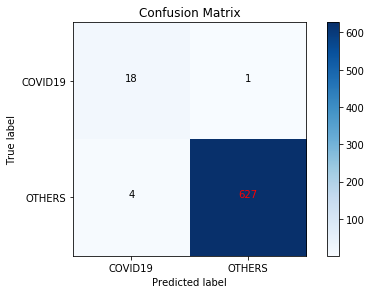

Normalized confusion matrix


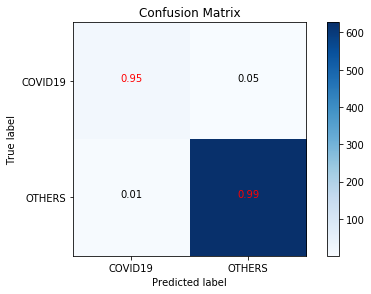

In [17]:
def plot_confusion_matrix(cm, classes,
    normalize=False,
    title='Confusion matrix',
    cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
y_pred = np.argmax(prediction, axis=1)
cm=confusion_matrix(test_generator.classes, y_pred)
cm_labels= ['COVID19','OTHERS']
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix')
plot_confusion_matrix(cm=cm, classes=cm_labels, title='Confusion Matrix', normalize=True)

## Show the prediction of model on some images of test-set

prob:[0.8650064 0.1349936]
COVID19/1-s2.0-S0929664620300449-gr2_lrg-a.jpg


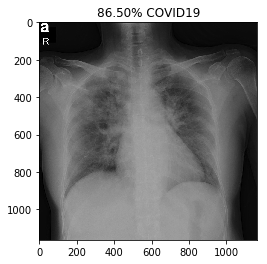

prob:[0.99527645 0.00472349]
COVID19/1-s2.0-S0929664620300449-gr3_lrg-d.jpg


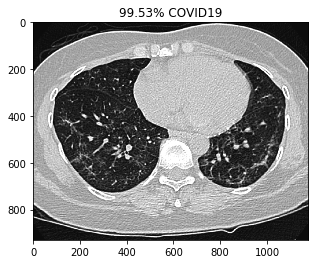

prob:[0.97915035 0.02084971]
COVID19/1-s2.0-S1684118220300608-main.pdf-002.jpg


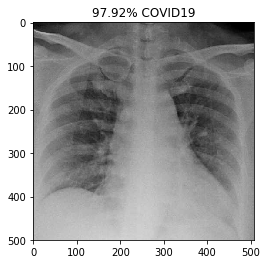

prob:[0.9952396  0.00476036]
COVID19/21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg


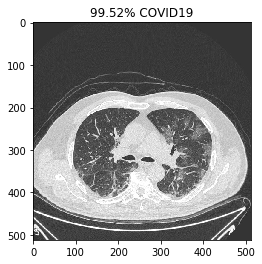

prob:[0.96194935 0.03805062]
COVID19/254B82FC-817D-4E2F-AB6E-1351341F0E38.jpeg


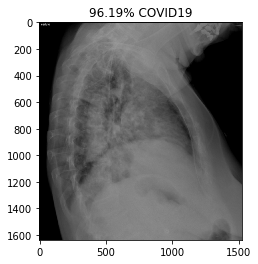

prob:[0.97726625 0.02273373]
COVID19/396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg


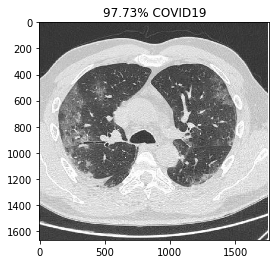

prob:[0.7482626  0.25173745]
COVID19/39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg


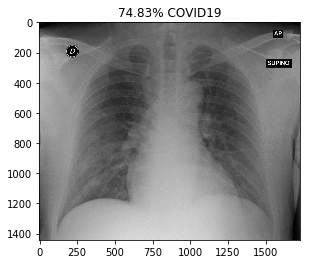

prob:[0.76025826 0.23974177]
COVID19/5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg


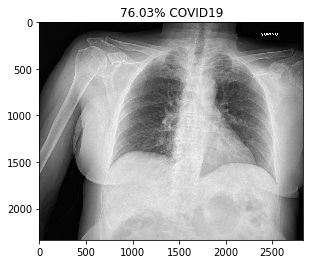

prob:[0.9229424  0.07705753]
COVID19/925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg


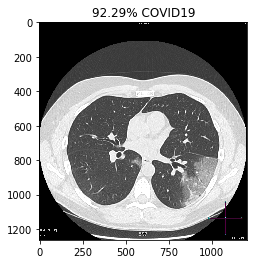

prob:[0.5135143  0.48648572]
COVID19/E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg


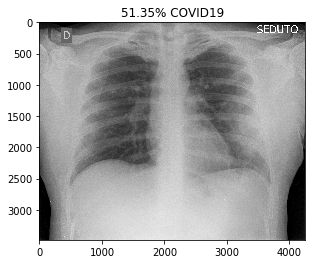

prob:[0.15298462 0.8470154 ]
COVID19/ciaa199.pdf-001-b.png


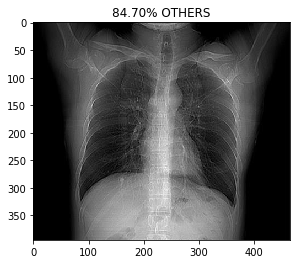

prob:[0.831242   0.16875798]
COVID19/covid-19-infection-exclusive-gastrointestinal-symptoms-pa.png


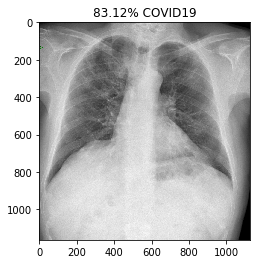

prob:[0.9680132  0.03198681]
COVID19/covid-19-pneumonia-15-PA.jpg


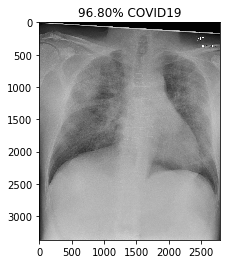

prob:[0.879095   0.12090495]
COVID19/covid-19-pneumonia-24-day7.jpg


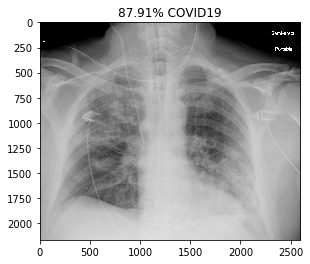

prob:[0.97347724 0.02652279]
COVID19/covid-19-pneumonia-30-PA.jpg


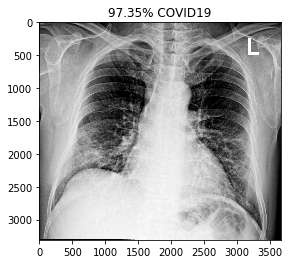

prob:[0.9188547  0.08114525]
COVID19/covid-19-pneumonia-rapidly-progressive-3-days.jpg


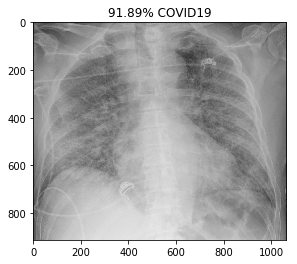

prob:[0.9435718  0.05642826]
COVID19/jkms-35-e79-g001-l-b.jpg


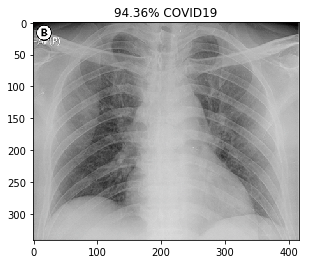

prob:[0.8709823 0.1290177]
COVID19/ryct.2020200028.fig1a.jpeg


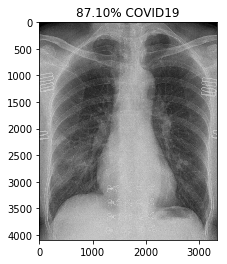

prob:[0.8589299  0.14107017]
COVID19/ryct.2020200034.fig2.jpeg


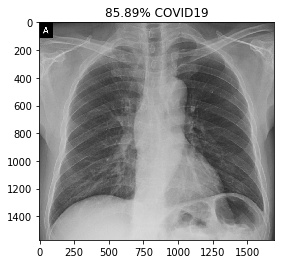

prob:[0. 1.]
OTHERS/IM-0001-0001.jpeg


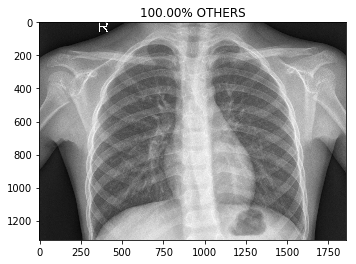

prob:[0. 1.]
OTHERS/IM-0003-0001.jpeg


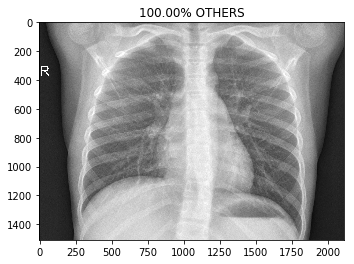

prob:[0. 1.]
OTHERS/IM-0005-0001.jpeg


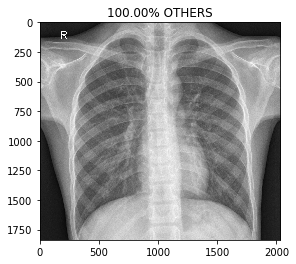

prob:[3.8558504e-20 1.0000000e+00]
OTHERS/IM-0006-0001.jpeg


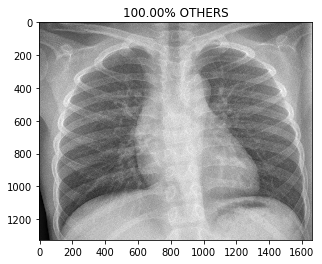

prob:[0. 1.]
OTHERS/IM-0007-0001.jpeg


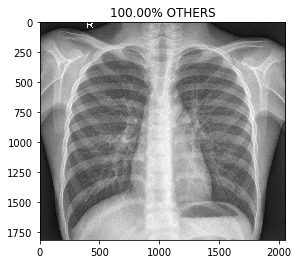

prob:[0. 1.]
OTHERS/IM-0009-0001.jpeg


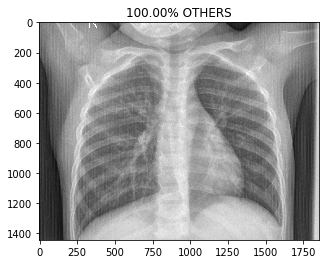

prob:[1.3383792e-35 1.0000000e+00]
OTHERS/IM-0010-0001.jpeg


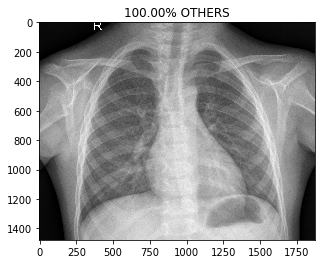

prob:[6.6624545e-38 1.0000000e+00]
OTHERS/IM-0011-0001-0001.jpeg


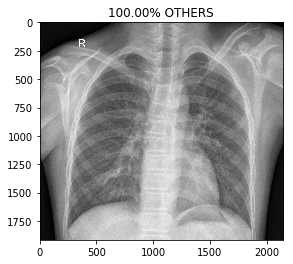

prob:[0. 1.]
OTHERS/IM-0011-0001-0002.jpeg


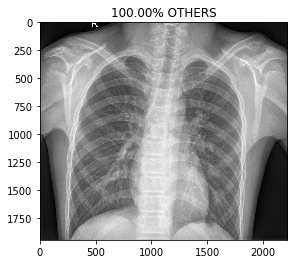

prob:[5.6387124e-31 1.0000000e+00]
OTHERS/IM-0011-0001.jpeg


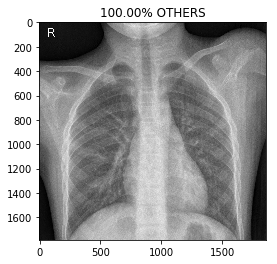

prob:[1.4633557e-25 1.0000000e+00]
OTHERS/IM-0013-0001.jpeg


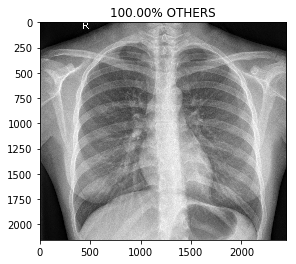

In [18]:
import cv2
import matplotlib.image as mpimg
prediction = prediction[:30]
for index, probability in enumerate(prediction):
    image_path = test_path + "/" +test_generator.filenames[index]
    image = mpimg.imread(image_path)
     #BGR TO RGB conversion using CV2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = np.array(image)
    plt.imshow(pixels)
    print("prob:{}".format(probability))
    print(test_generator.filenames[index])
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% OTHERS')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% COVID19')
    plt.show()

## Plotting ROC curve and generating classification report

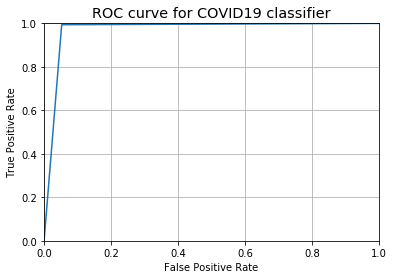

In [19]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(test_generator.classes, y_pred)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for COVID19 classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [20]:
print('Classification Report')
target_names = ['COVID19','OTHERS']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     COVID19       0.82      0.95      0.88        19
      OTHERS       1.00      0.99      1.00       631

    accuracy                           0.99       650
   macro avg       0.91      0.97      0.94       650
weighted avg       0.99      0.99      0.99       650

